# Quantum Kernel Machine with entangled Qubits



<img src="../logo_circular.png" width="20" height="20" />@by claudio<br>
nonlinearxwaves@gmail.com<br>


@created 9 feb 2022<br>
@version 10 july 2022

In [1]:
from thqml import quantummap as qm
import tensorflow as  tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_classification
from matplotlib import cm
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

2022-07-10 16:34:30.146674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-10 16:34:30.146699: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-10 16:34:31.502218: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-10 16:34:31.502236: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-10 16:34:31.502251: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist
2022-07-10 16:34:31.502447: I tensorflow/core/platform/cpu_feature_guard.c

# Number of qubits

In [2]:
n=2

Test the quantum map module

In [3]:
qm.Isingle

<tf.Tensor: shape=(2, 2), dtype=complex64, numpy=
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]], dtype=complex64)>

In [4]:
qm.IX

<tf.Tensor: shape=(2, 2, 2, 2), dtype=complex64, numpy=
array([[[[0.+0.j, 1.+0.j],
         [1.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]]],


       [[[0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j]],

        [[0.+0.j, 1.+0.j],
         [1.+0.j, 0.+0.j]]]], dtype=complex64)>

In [5]:
qm.Zsingle.shape

TensorShape([2, 2])

In [6]:
qm.q00

<tf.Tensor: shape=(2, 2), dtype=complex64, numpy=
array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]], dtype=complex64)>

In [7]:
qm.Gate(qm.ZZ, qm.q11)

<tf.Tensor: shape=(2, 2), dtype=complex64, numpy=
array([[0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]], dtype=complex64)>

In [8]:
qm.Gate(qm.IZ, qm.q10)

<tf.Tensor: shape=(2, 2), dtype=complex64, numpy=
array([[0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j]], dtype=complex64)>

In [9]:
qm.ZZ.shape

TensorShape([2, 2, 2, 2])

In [10]:
psi=qm.q00

# Feature Map

In [11]:
@tf.function
def FeatureMapU(psi, theta):
    thetaZ0=theta[0]
    thetaZ1=theta[1]
    thetaZZ=theta[2]
    psi=qm.Gate(qm.HH,psi)
    psi=qm.Gate(qm.EZI(thetaZ0),psi)
    psi=qm.Gate(qm.EIZ(thetaZ1),psi)
    psi=qm.Gate(qm.EZZ(thetaZZ),psi)
    return psi

# Iterated Feature Map

In [12]:
@tf.function
def FeatureMapUU(psi, theta):
    psi = FeatureMapU(psi, theta)
    psi = FeatureMapU(psi, theta)
    return psi

Test the feature map

In [13]:
Upsi=FeatureMapUU(psi, tf.constant(np.random.random(3)))

In [14]:
print(Upsi)

tf.Tensor(
[[-0.00060399+0.49045366j -0.2026321 +0.46717805j]
 [ 0.20271425+0.46757013j  0.00061181+0.49033052j]], shape=(2, 2), dtype=complex64)


Test the scalar product

In [15]:
qm.Scalar(Upsi,Upsi)

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[0.9999995+0.j]], dtype=complex64)>

In [16]:
Uphi=FeatureMapU(psi, np.random.random(3))

In [17]:
qm.Scalar(Uphi,Upsi)

<tf.Tensor: shape=(1, 1), dtype=complex64, numpy=array([[-0.01430573+0.38748023j]], dtype=complex64)>

# Define the Kernel function

## Map x to theta 

In [18]:
def MapTheta(x):
    """ take a two vector and return a theta vector """
    theta0=x[0]
    theta1=x[1]
    theta01=(np.pi-x[0])*(np.pi-x[1])
    return [theta0, theta1,theta01]

## Kernel function

In [19]:
def Kernel_np(xA_np,xB_np):
    """ compute the Kernel function """
    nb1, nx= xA_np.shape
    nb2, ny= xB_np.shape
    out = np.zeros((nb1,nb2))
    for i1 in range(nb1):
        for i2 in range(nb2):
            xB=[tf.constant(xB_np[i2,0]),tf.constant(xB_np[i2,1])]
            xA=[tf.constant(xA_np[i1,0]),tf.constant(xA_np[i1,1])]
            thetaA=MapTheta(xA)
            thetaB=MapTheta(xB)
            psiA=FeatureMapUU(qm.q00,thetaA)
            psiB=FeatureMapUU(qm.q00,thetaB)
            sc=qm.Scalar(psiA,psiB)
            abs2 = tf.square(tf.abs(sc))
            out[i1,i2]=abs2.numpy()
    return out

# Plot the kernel function

In [20]:
%%time
nplot=100
x1 =np.zeros([nplot,2])
x2 =np.zeros([nplot,2])
x1[:,0] = np.linspace(-2*np.pi,2*np.pi,nplot)
x1[:,1] = np.linspace(-2*np.pi,2*np.pi,nplot)

# Compute data for coherent state kernel
COEPLOT=np.zeros((nplot,nplot))
x1tmp=np.zeros((1,2))
x2tmp=np.zeros((1,2))
for i1 in range(nplot):
    x1tmp[0,0]=x1[i1,0]
    x2tmp[0,0]=x2[i1,0]
    for i2 in range(nplot):
        x1tmp[0,1]=x1[i2,1]
        x2tmp[0,1]=x2[i2,1]
        COEPLOT[i1,i2]=Kernel_np(x1tmp,x2tmp)
        


CPU times: user 10.3 s, sys: 515 ms, total: 10.8 s
Wall time: 8.9 s


CPU times: user 2.74 s, sys: 1.15 s, total: 3.9 s
Wall time: 1.63 s


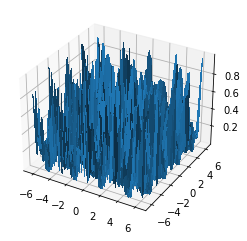

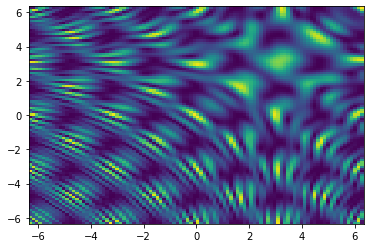

In [21]:
%%time 
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
[X,Y]=np.meshgrid(x1[:,0],x1[:,1])
#surf = ax.plot_surface(X,Y , COEPLOT, antialiased=False, linewidth=0)
#surf = ax.plot_surface(X,Y , COEPLOT, antialiased=False, cmap=colorm.coolwarm, linewidth=0)
surf = ax.plot_surface(X,Y , COEPLOT, antialiased=False, linewidth=0)
plt.savefig('./kernelQubits.pdf', format='pdf')
#plt.show()
fig, ax= plt.subplots()
plt.pcolor(X,Y,COEPLOT)
plt.savefig('./kernelQubits2.pdf', format='pdf')


# Create dataset

In [22]:
X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

In [23]:
datasets = [
    make_moons(noise=0.1, random_state=0),
    make_circles(noise=0.1, factor=0.5, random_state=1),
]

In [24]:
classifiers = [
    SVC(kernel=Kernel_np),
]
names=['EntangledQubits']

# Fit

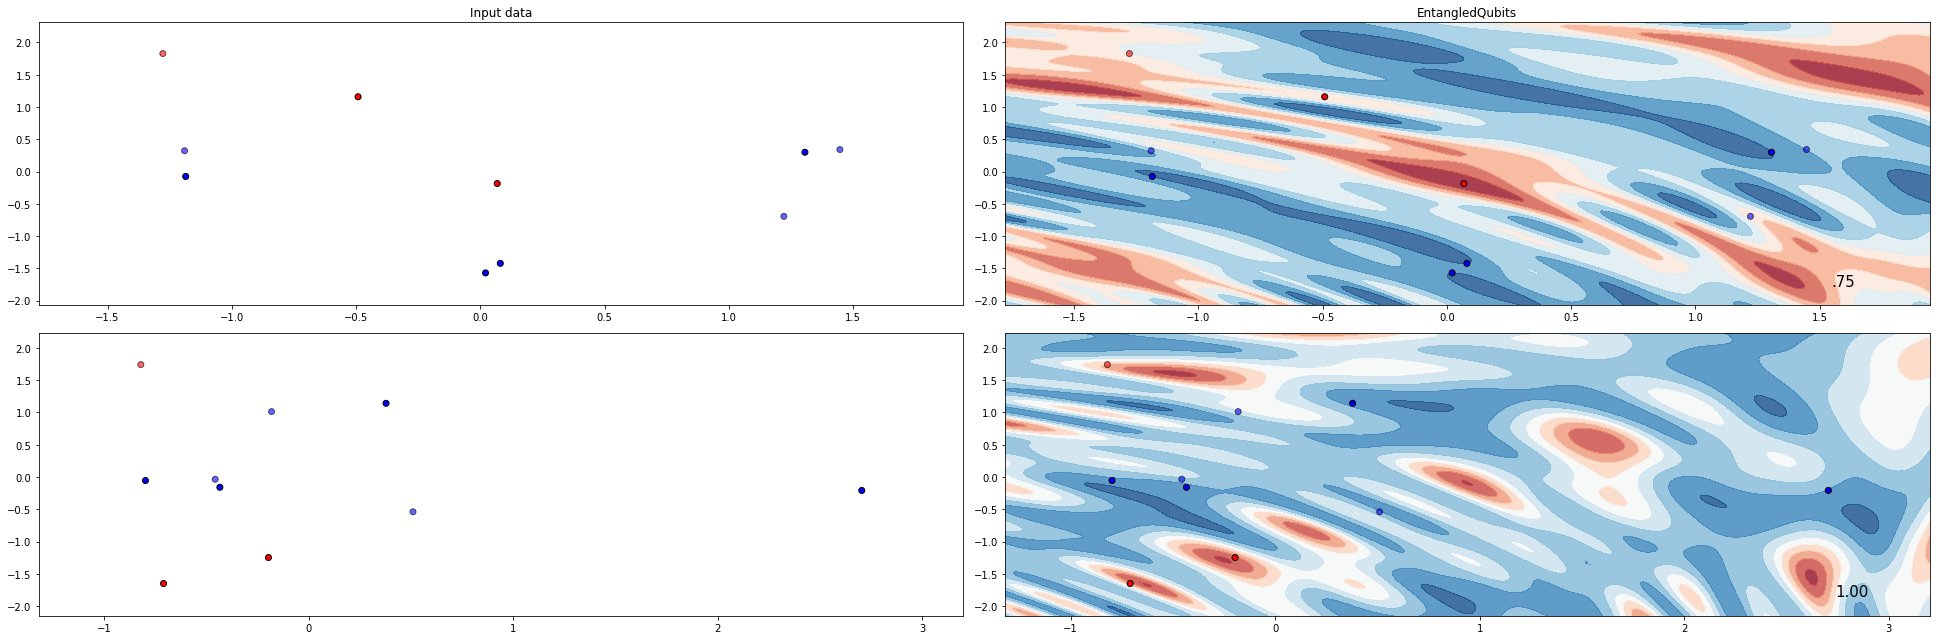

CPU times: user 12min 29s, sys: 36.3 s, total: 13min 5s
Wall time: 10min 42s


In [25]:
%%time
datapoints=10
h = 0.02  # step size in the mesh
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X=X[:datapoints,:]
    y=y[:datapoints]
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train,
               cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    #ax.set_xticks(())
    #ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:,
                                   1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        #ax.set_xticks(())
        #ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
#lt.savefig('./jupyternotebooks/quantumfeaturemap/EntangledQubit.pdf', format='pdf')
plt.show() #remark, plt.show() must come after plt.savefig

Compute the score

In [26]:
clf.score(X_train, y_train)

1.0

Test the trained network

In [27]:
print(clf.predict(X_train[:3,:]))

[1 0 1]


In [28]:
clf.predict(X_train)

array([1, 0, 1, 1, 1, 0])